# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [1]:
## DATA DICTIONARY

In [33]:
import pandas as pd
import json
import seaborn as sns
%matplotlib inline


data = pd.read_csv("../dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', '')) # parse out json blob
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

In [5]:
# 'double' = float with greater precisions

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [6]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

> ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

count    7395.000000
mean        0.275709
std         1.919320
min        -1.000000
25%         0.025900
50%         0.083051
75%         0.236700
max       113.333333
Name: image_ratio, dtype: float64


0    0
1    0
2    0
3    0
4    0
Name: high_image_page, dtype: int64

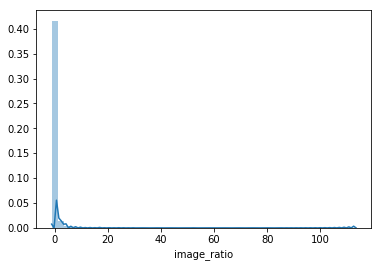

In [22]:
# convert image_ratio into binary values rather than using actual ratios - why?
test = data[['image_ratio','label']]
test.head()
print test.image_ratio.describe()
# results shoow most of the data points are under 75%
sns.distplot(test.image_ratio)
# so, roll them up in a new column that defines if a row item is classified as high_image_page or not
data['high_image_page'] = data['image_ratio'].map(lambda x: int(x > (0.2367)))
data['high_image_page'].head()

> ### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [28]:
# Use the crosstab function

print pd.crosstab(data['label'], data['is_news'] , rownames=['label'])
odds_ifnews = float(2353)/2199
odds_notnews = float(1443)/1400
print odds_ifnews/odds_notnews

is_news     1     ?
label              
0        2199  1400
1        2353  1443
1.03814592218


> ### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

In [30]:
# ... #
print data.alchemy_category.unique()

['business' 'recreation' 'health' 'sports' '?' 'arts_entertainment'
 'science_technology' 'gaming' 'culture_politics' 'computer_internet'
 'law_crime' 'religion' 'weather' 'unknown']


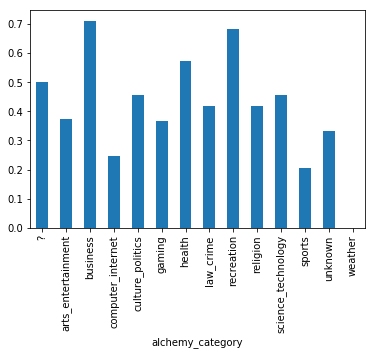

In [37]:
data.groupby('alchemy_category').label.mean().plot(kind = 'bar')

> ### Exercise: 5. How many articles are there per category?

In [39]:
# ... #
print data.alchemy_category.value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64


In [100]:
# check for null values in the column
data.alchemy_category.isnull().sum()
#.sum() will sum the values from Ts and Fs, which are 1s and 0s, aka the count of TRUEs

0

In [101]:
def function_recipe(x):
    if x is None: # check for null cases first
        return False
    if ('sports' in x.lower())|('business' in x.lower())|('culture_politics' in x.lower())|('weather' in x.lower()):
        return True
    else: 
        return False
    
    
# if ('recipe' in x.lower()) | ():

In [103]:
# quick check on the function

a = 'null jack'
function_recipe(a)

False

In [105]:
data['higher_alchemy_category'] = data.alchemy_category.map(function_recipe)
data['higher_alchemy_category'].head()

0     True
1    False
2    False
3    False
4     True
Name: higher_alchemy_category, dtype: bool

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [48]:
# check for null values in the column
data.title.isnull().sum()
#.sum() will sum the values from Ts and Fs, which are 1s and 0s, aka the count of TRUEs

12

In [54]:
def function_recipe(x):
    if x is None: # check for null cases first
        return False
    if 'recipe' in x.lower():
        return True
    else: 
        return False
    
    
# if ('recipe' in x.lower()) | ():

In [55]:
# quick check on the function

a = 'recipe jack'
function_recipe(a)

True

In [59]:
data['recipe'] = data.title.map(function_recipe)
data['recipe'].head()

0    False
1    False
2    False
3    False
4    False
Name: recipe, dtype: bool

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [60]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier() # inittializer

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna() # including y variable to ensure all rows still line up
y = X['label']
X.drop('label', axis=1, inplace=True) # drop the outcome variable from the X columns
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
   # system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

In [ ]:
# by asking the same questions back and forth, decision trees take care of the interactions amongst different variables
# e.g. you feel uncomfy when temp is high, but when wind is strong, you might start to feel uncomfy even at a lower temp
# multi-colinearity is also taken care of

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [77]:
# import sklearn functions #

from sklearn.model_selection import cross_val_score, cross_validate

cross_validate(model, X, y, groups=None, scoring=['roc_auc','accuracy'], cv=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score='false')
# print cv_results['test_score'] # accuracy of the model
# you can add multiple scores into this one line of code

{'fit_time': array([ 0.03299999,  0.01800013,  0.00600004]),
 'score_time': array([ 0.00399995,  0.00199986,  0.        ]),
 'test_accuracy': array([ 0.53568532,  0.57768763,  0.57021104]),
 'test_roc_auc': array([ 0.53560229,  0.57756324,  0.56976103]),
 'train_accuracy': array([ 0.99979712,  0.99979716,  1.        ]),
 'train_roc_auc': array([ 0.99999992,  0.99999992,  1.        ])}

###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [79]:
# manually control for overfitting
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
build_tree_image(model)
cross_validate(model, X, y, groups=None, scoring=['roc_auc','accuracy'], cv=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score='false')

{'fit_time': array([ 0.00999999,  0.00600004,  0.00500011]),
 'score_time': array([ 0.00300002,  0.00399995,  0.00199986]),
 'test_accuracy': array([ 0.58515815,  0.60040568,  0.58685065]),
 'test_roc_auc': array([ 0.62764284,  0.63169993,  0.628443  ]),
 'train_accuracy': array([ 0.59362954,  0.58600406,  0.59278037]),
 'train_roc_auc': array([ 0.63946984,  0.62563059,  0.63991933])}

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [80]:
# initializing the model
# randomness takes care of overfitting

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20) # the number of tress in the forest
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
# elements for tuning using grid search
# n_estimators
# max_depth
# min_seamples_leaf
# n_jobs = -1 (all CPUs in the work)

In [91]:
# cross_val_score(model, X, y, scoring = 'roc_auc')
# cross_validate(model, X, y, groups=None, scoring=['roc_auc','accuracy'], cv=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score='false')

array([ 0.61373552,  0.63749045,  0.62262524])

### Demo: Extracting importance of features

In [89]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.499960
0,image_ratio,0.411029
2,recipe,0.089011


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [ ]:
# ... #

##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [93]:
data.is_news.unique()
data.is_news = data.is_news.map({'1':1, '?':0})

In [147]:
X = data[['image_ratio', 'html_ratio', 'recipe', 'label','higher_alchemy_category','lengthyLinkDomain','linkwordscore','avglinksize','hasDomainLink']].dropna() # including y variable to ensure all rows still line up
y = X['label']
X.drop('label', axis=1, inplace=True) # drop the outcome variable from the X columns

KeyError: "['frameBased'] not in index"

In [145]:
model = RandomForestClassifier(n_estimators = 40, n_jobs = -1, max_depth = 4, min_samples_split = 30) # the number of tress in the forest
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [146]:
cross_validate(model, X, y, groups=None, scoring=['roc_auc','accuracy'], cv=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score='false')

{'fit_time': array([ 0.22399998,  0.20300007,  0.25399995]),
 'score_time': array([ 0.26799989,  0.26499987,  0.28700018]),
 'test_accuracy': array([ 0.63746959,  0.67180527,  0.65340909]),
 'test_roc_auc': array([ 0.70938389,  0.73824506,  0.71595829]),
 'train_accuracy': array([ 0.68431731,  0.66551724,  0.66680187]),
 'train_roc_auc': array([ 0.74992734,  0.73616542,  0.74271426])}

In [149]:
data.frameBased.isnull().sum()

AttributeError: 'DataFrame' object has no attribute 'frameBased'